In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.pad import pad, adj_pad
from ppfft.tools.new_fft import new_fft, adj_new_fft, new_fft2
from ppfft.resampling.inverse_toeplitz import InverseToeplitz
from ppfft.resampling.fast_resampling import compute_inverse

# Old version

In [2]:
def D(n):
    q_n, r_n = divmod(n, 2)
    return np.arange(-q_n, q_n + r_n)

def F_D(x):
    n = len(x)
    m = 2 * n + 1
    pad_x = pad(x, (m,))

    fft = new_fft(pad_x)

    if n%2 == 0:
        return fft[::2]
    
    else:
        return np.roll(fft, 1)[::2]

def check_F_D(x):
    n = len(x)
    m = 2 * n + 1
    k = D(n + 1)
    u = D(n)
    ku = np.einsum("k,u->ku", k, u)
    res = np.einsum("u,ku->k", x, np.exp(-2j * np.pi * 2 * ku / m))
    return res

def adj_F_D(y):
    n = len(y) - 1
    m = 2 * n + 1
    aux = np.zeros(shape=(m,), dtype=complex)
    aux[::2] = y

    if n%2 == 0:
        return adj_pad(adj_new_fft(aux), original_shape=(n,))
    
    else:
        return adj_pad(adj_new_fft(np.roll(aux, -1)), original_shape=(n,))

In [3]:
def compute_FDdaggerFD(n):
    m = 2 * n + 1
    u = D(n + 1)
    k_minus_l = D(n)[:, None] - D(n)[None, :]
    u_times_k_minus_l = np.einsum("u,kl->ukl", u, k_minus_l)
    return np.einsum("ukl->kl", np.exp(4j * np.pi * u_times_k_minus_l / m))

In [4]:
def solve_min(y):
    n = len(y) - 1
    T = compute_FDdaggerFD(n)
    inv_T = compute_inverse(T[:, 0])
    return inv_T @ adj_F_D(y)

In [5]:
def inverse_Id(Id):
    n = Id.shape[0] - 1

    A = np.zeros(shape=(n, n + 1), dtype=complex)
    res = np.zeros(shape=(n, n), dtype=complex)
    
    for l, col in enumerate(Id.T):
        A[:, l] = solve_min(col)

    for u, row in enumerate(A):
        res[u, :] = solve_min(row)

    return res

# Fast version

In [6]:
def compute_col(n):
    m = 2 * n + 1
    one = np.ones(n + 1)
    pad_one = pad(one, (m,))

    q_m, r_m = divmod(m, 2)

    indices = (2 * np.arange(0, n)) % m  # between 0 and m - 1
    indices[indices >= q_m + r_m] -= m  # between -m//2 and -1
    indices += q_m

    return np.take(adj_new_fft(pad_one), indices)

In [7]:
print(np.max(np.abs(compute_col(20) - compute_FDdaggerFD(20)[:, 0])))
print(np.max(np.abs(compute_col(21) - compute_FDdaggerFD(21)[:, 0])))


1.4654943925052066e-14
1.6479240474680055e-14


In [8]:
def precompute_inverse_Id(n):

    c = compute_col(n)

    return InverseToeplitz(col=c)


def fast_inverse_Id(Id, toeplitz: InverseToeplitz):
    n = Id.shape[0] - 1

    A = np.zeros(shape=(n, n + 1), dtype=complex)
    res = np.zeros(shape=(n, n), dtype=complex)
    
    for l, col in enumerate(Id.T):
        A[:, l] = toeplitz.apply_inverse(adj_F_D(col))

    for u, row in enumerate(A):
        res[u, :] = toeplitz.apply_inverse(adj_F_D(row))

    return res

# Test

In [14]:
def create_shepp_logan(n):
    x, y = np.linspace(-1, 1, n), np.linspace(-1, 1, n)
    xx, yy = np.meshgrid(x, y)
    res = np.zeros_like(xx)

    A_list = [1, -0.8, -0.2, -0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
    a_list = [0.69, 0.6624, 0.11, 0.16, 0.21, 0.046, 0.046, 0.046, 0.023, 0.023]
    b_list = [0.92, 0.874, 0.31, 0.41, 0.25, 0.046, 0.046, 0.023, 0.023, 0.046]
    phi_list = [0, 0, -18 * np.pi / 180, 18 * np.pi / 180, 0, 0, 0, 0, 0, 0]
    x0_list = [0, 0, 0.22, -0.22, 0, 0, 0, -0.08, 0, 0.06]
    y0_list = [0, -0.0184, 0, 0, 0.35, 0.1, -0.1, -0.605, -0.605, -0.605]

    for A, a, b, phi, x0, y0 in zip(A_list, a_list, b_list, phi_list, x0_list, y0_list):
        rot_x = xx * np.cos(phi) + yy * np.sin(phi)
        rot_y = - np.sin(phi) * xx + yy * np.cos(phi)
        mask = (rot_x - x0)**2 / a**2 + (rot_y - y0)**2 / b**2 <= 1
        res[mask] += A

    return res[::-1]

In [15]:
def compute_true_Id(im):
    n = len(im)
    m = 2 * n + 1
    pad_im = pad(im, (m, m))
    return new_fft2(pad_im)[::2, ::2]

In [22]:
n = 2000
im = create_shepp_logan(n)
Id = compute_true_Id(im)

In [ ]:
toeplitz = precompute_inverse_Id(im.shape[0])
fast_sol = fast_inverse_Id(Id, toeplitz)

/tmp/ipykernel_30948/2497543058.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(im - fast_sol)))


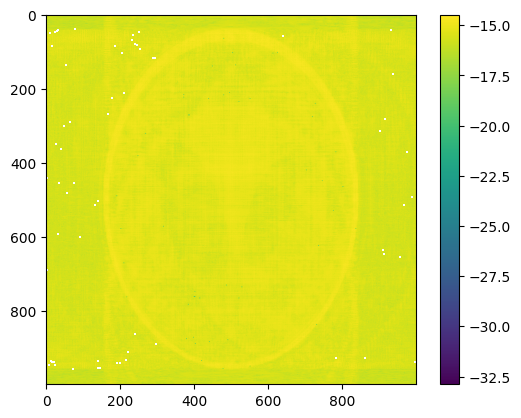

In [17]:
plt.imshow(np.log10(np.abs(im - fast_sol)))
plt.colorbar()

In [19]:
from ppfft.tools.new_fft import new_ifft2

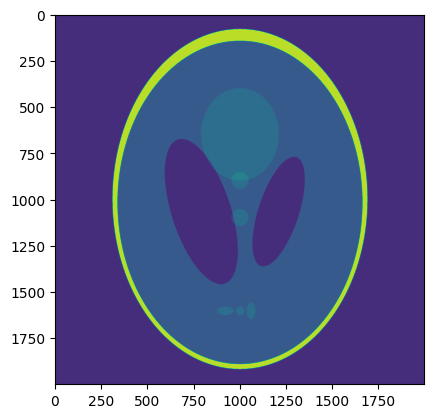

In [25]:
plt.imshow(new_ifft2(Id[:-1,:-1]).real)

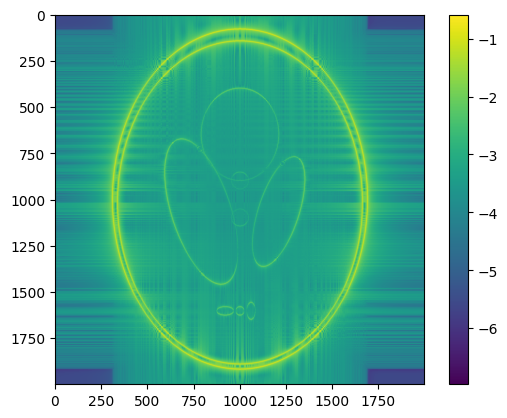

In [23]:
plt.imshow(np.log10(np.abs(im - new_ifft2(Id[:-1,:-1]))))
plt.colorbar()

# Using symmetry

In [ ]:
def fast_inverse_Id(Id, toeplitz: InverseToeplitz):
    n = Id.shape[0] - 1

    A = np.zeros(shape=(n, n + 1), dtype=complex)
    res = np.zeros(shape=(n, n), dtype=complex)
    
    for l, col in enumerate(Id.T):
        A[:, l] = toeplitz.apply_inverse(adj_F_D(col))

    for u, row in enumerate(A):
        res[u, :] = toeplitz.apply_inverse(adj_F_D(row))

    return res